# Incorporate CBAM (Convolutional Block Attention Module) into our U-Net model

We Define the CBAM modules: Both the ChannelAttention and SpatialAttention modules.
Integrate the CBAM module into the U-Net architecture: Add CBAM to the relevant layers in the network.
Update the training loop: Ensure the new model works correctly with the training and validation code.a

In [67]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Device setup for MPS (Metal Performance Shaders)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Define the AdvancedTransform class for training
class AdvancedTransform:
    def __init__(self):
        self.common_augmentation = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=1.0),
            A.Affine(
                rotate=(-15, 15),
                translate_percent=(0.1, 0.1),
                scale=(0.8, 1.2),
                shear=10,
                p=0.5
            ),
            A.ElasticTransform(alpha=1.0, sigma=50, p=0.5),
            A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
            A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        ])
        
        self.image_augmentation = A.Compose([
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        ])

    def __call__(self, image, mask):
        seed = random.randint(0, 2**32)
        
        random.seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        image = np.array(image)
        mask = np.array(mask)
        
        # Apply transformations
        transformed = self.common_augmentation(image=image, mask=mask)
        image, mask = transformed['image'], transformed['mask']

        image = self.image_augmentation(image=image)['image']

        # Convert numpy array back to PIL image
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)
        
        return transforms.ToTensor()(image), transforms.ToTensor()(mask)

# Define a simple transform class for validation
class SimpleTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __call__(self, image, mask):
        image = self.transform(image)
        mask = self.transform(mask)
        return image, mask

# Define the KvasirSegDataset class
class KvasirSegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image, mask = self.transform(image, mask)
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)

        return image, mask

# Paths to images and masks
img_dir = '/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/images'
mask_dir = '/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/masks'

# Get image and mask paths
image_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir)]
mask_paths = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)]

# Split data into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

# Create transform objects
advanced_transform = AdvancedTransform()
simple_transform = SimpleTransform()

# Create datasets with the appropriate transform
train_dataset = KvasirSegDataset(train_image_paths, train_mask_paths, transform=advanced_transform)
val_dataset = KvasirSegDataset(val_image_paths, val_mask_paths, transform=simple_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


Using device: mps


### CBAM Modules

In [68]:
import torch
import torch.nn as nn

# Define the SE Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        se = self.global_avg_pool(x)
        se = self.fc1(se)
        se = self.relu(se)
        se = self.fc2(se)
        se = self.sigmoid(se)
        return x * se

# Define the CBAM block
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.global_avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.global_max_pool(x))))
        return x * self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, in_channels, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size - 1) // 2)
        self.sigmoid = nn.Sigmoid()
        self.expand_channels = nn.Conv2d(1, in_channels, kernel_size=1)  # Add this line

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out = torch.max(x, dim=1, keepdim=True)[0]
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.sigmoid(self.conv(x))
        x = self.expand_channels(x)  # Add this line
        return x * x


class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(in_channels, kernel_size)  # Pass in_channels

    def forward(self, x):
        x = self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x


# Define the U-Net architecture with SE and CBAM blocks
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=128):
        super(UNet, self).__init__()

        features = init_features
        self.down1 = self.conv_block(in_channels, features)
        self.down2 = self.conv_block(features, features * 2)
        self.down3 = self.conv_block(features * 2, features * 4)
        self.down4 = self.conv_block(features * 4, features * 8)
        self.down5 = self.conv_block(features * 8, features * 16)

        self.up1 = self.up_conv_block(features * 16, features * 8)
        self.up_conv1 = self.conv_block(features * 16, features * 8)
        self.up2 = self.up_conv_block(features * 8, features * 4)
        self.up_conv2 = self.conv_block(features * 8, features * 4)
        self.up3 = self.up_conv_block(features * 4, features * 2)
        self.up_conv3 = self.conv_block(features * 4, features * 2)
        self.up4 = self.up_conv_block(features * 2, features)
        self.up_conv4 = self.conv_block(features * 2, features)
        self.final_conv = nn.Conv2d(features, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),  # BatchNorm before CBAM
            SEBlock(out_channels),  # Add SEBlock after BatchNorm
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            CBAM(out_channels),  # Add CBAM after the second convolution
        )

    def up_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(nn.functional.max_pool2d(down1, 2))
        down3 = self.down3(nn.functional.max_pool2d(down2, 2))
        down4 = self.down4(nn.functional.max_pool2d(down3, 2))
        down5 = self.down5(nn.functional.max_pool2d(down4, 2))

        up1 = self.up1(down5)
        up1 = torch.cat([up1, down4], dim=1)
        up1 = self.up_conv1(up1)
        up2 = self.up2(up1)
        up2 = torch.cat([up2, down3], dim=1)
        up2 = self.up_conv2(up2)
        up3 = self.up3(up2)
        up3 = torch.cat([up3, down2], dim=1)
        up3 = self.up_conv3(up3)
        up4 = self.up4(up3)
        up4 = torch.cat([up4, down1], dim=1)
        up4 = self.up_conv4(up4)

        out = self.final_conv(up4)
        return self.sigmoid(out)


In [69]:
# Adjust init_features to control the width of the network
Attntion_WD_Aug_model = UNet(in_channels=3, out_channels=1, init_features=64).to(device)

In [83]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(Attntion_WD_Aug_model.parameters(), lr=0.01, momentum=0.9)

# Define metrics: Dice coefficient and IoU
def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    return dice.mean()

def iou(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    union = (pred + target).sum(dim=2).sum(dim=2) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

### Updated U-Net with CBAM

In [64]:
# Training and validation loop
num_epochs = 50
train_losses = []
val_losses = []  # To store validation loss
val_dice_scores = []
val_ious = []

for epoch in range(num_epochs):
    Attntion_WD_Aug_model.train()
    epoch_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = Attntion_WD_Aug_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Validation
    Attntion_WD_Aug_model.eval()
    val_loss = 0.0  # Initialize validation loss
    val_dice = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = Attntion_WD_Aug_model(images)
            loss = criterion(outputs, masks)  # Compute validation loss
            val_loss += loss.item() * images.size(0)
            preds = outputs > 0.5
            val_dice += dice_coefficient(preds, masks).item() * images.size(0)
            val_iou += iou(preds, masks).item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)  # Store validation loss
    val_dice /= len(val_loader.dataset)
    val_dice_scores.append(val_dice)
    val_iou /= len(val_loader.dataset)
    val_ious.append(val_iou)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}, Validation IoU: {val_iou:.4f}')

UNetWithCBAM(
  (down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down4): S

### Training and Evaluation

Summary
Added CBAM: Integrated both channel and spatial attention modules.
Updated U-Net: Added CBAM modules to the relevant layers.
Kept Training and Evaluation: No changes needed to the training loop apart from updating the model.
This code integrates the CBAM into your U-Net architecture and should help improve your model's performance by focusing on more relevant features and spatial regions.

In [71]:
# Training and validation loop
num_epochs = 50
train_losses = []
val_losses = []  # To store validation loss
val_dice_scores = []
val_ious = []

for epoch in range(num_epochs):
    Attntion_WD_Aug_model.train()
    epoch_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = Attntion_WD_Aug_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Validation
    Attntion_WD_Aug_model.eval()
    val_loss = 0.0  # Initialize validation loss
    val_dice = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = Attntion_WD_Aug_model(images)
            loss = criterion(outputs, masks)  # Compute validation loss
            val_loss += loss.item() * images.size(0)
            preds = outputs > 0.5
            val_dice += dice_coefficient(preds, masks).item() * images.size(0)
            val_iou += iou(preds, masks).item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)  # Store validation loss
    val_dice /= len(val_loader.dataset)
    val_dice_scores.append(val_dice)
    val_iou /= len(val_loader.dataset)
    val_ious.append(val_iou)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}, Validation IoU: {val_iou:.4f}')

Epoch 1/50: 100%|█████████████████████████████| 200/200 [03:08<00:00,  1.06it/s]


Epoch [1/50], Loss: 0.4010
Epoch [1/50], Validation Loss: 0.3564, Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 2/50: 100%|█████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [2/50], Loss: 0.3731
Epoch [2/50], Validation Loss: 0.3546, Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 3/50: 100%|█████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [3/50], Loss: 0.3659
Epoch [3/50], Validation Loss: 0.3610, Validation Dice: 0.0049, Validation IoU: 0.0027


Epoch 4/50: 100%|█████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [4/50], Loss: 0.3566
Epoch [4/50], Validation Loss: 0.3389, Validation Dice: 0.3384, Validation IoU: 0.2407


Epoch 5/50: 100%|█████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [5/50], Loss: 0.3388
Epoch [5/50], Validation Loss: 0.3054, Validation Dice: 0.3963, Validation IoU: 0.2935


Epoch 6/50: 100%|█████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [6/50], Loss: 0.3269
Epoch [6/50], Validation Loss: 0.3190, Validation Dice: 0.2081, Validation IoU: 0.1508


Epoch 7/50: 100%|█████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [7/50], Loss: 0.3134
Epoch [7/50], Validation Loss: 0.2796, Validation Dice: 0.3261, Validation IoU: 0.2426


Epoch 8/50: 100%|█████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [8/50], Loss: 0.3010
Epoch [8/50], Validation Loss: 0.3027, Validation Dice: 0.4730, Validation IoU: 0.3642


Epoch 9/50: 100%|█████████████████████████████| 200/200 [03:04<00:00,  1.08it/s]


Epoch [9/50], Loss: 0.2826
Epoch [9/50], Validation Loss: 0.2776, Validation Dice: 0.3754, Validation IoU: 0.2923


Epoch 10/50: 100%|████████████████████████████| 200/200 [03:05<00:00,  1.08it/s]


Epoch [10/50], Loss: 0.2728
Epoch [10/50], Validation Loss: 0.2596, Validation Dice: 0.5400, Validation IoU: 0.4347


Epoch 11/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [11/50], Loss: 0.2479
Epoch [11/50], Validation Loss: 0.2285, Validation Dice: 0.6604, Validation IoU: 0.5462


Epoch 12/50: 100%|████████████████████████████| 200/200 [03:00<00:00,  1.11it/s]


Epoch [12/50], Loss: 0.2350
Epoch [12/50], Validation Loss: 0.2747, Validation Dice: 0.6246, Validation IoU: 0.5052


Epoch 13/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [13/50], Loss: 0.2237
Epoch [13/50], Validation Loss: 0.2225, Validation Dice: 0.5291, Validation IoU: 0.4314


Epoch 14/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [14/50], Loss: 0.2227
Epoch [14/50], Validation Loss: 0.1886, Validation Dice: 0.7252, Validation IoU: 0.6216


Epoch 15/50: 100%|████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [15/50], Loss: 0.2205
Epoch [15/50], Validation Loss: 0.1795, Validation Dice: 0.7368, Validation IoU: 0.6370


Epoch 16/50: 100%|████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [16/50], Loss: 0.2097
Epoch [16/50], Validation Loss: 0.1979, Validation Dice: 0.6778, Validation IoU: 0.5859


Epoch 17/50: 100%|████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [17/50], Loss: 0.2072
Epoch [17/50], Validation Loss: 0.1811, Validation Dice: 0.7068, Validation IoU: 0.6166


Epoch 18/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [18/50], Loss: 0.1958
Epoch [18/50], Validation Loss: 0.2428, Validation Dice: 0.6313, Validation IoU: 0.5445


Epoch 19/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [19/50], Loss: 0.2004
Epoch [19/50], Validation Loss: 0.1630, Validation Dice: 0.7657, Validation IoU: 0.6663


Epoch 20/50: 100%|████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [20/50], Loss: 0.1981
Epoch [20/50], Validation Loss: 0.1656, Validation Dice: 0.7567, Validation IoU: 0.6618


Epoch 21/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [21/50], Loss: 0.1951
Epoch [21/50], Validation Loss: 0.1588, Validation Dice: 0.7584, Validation IoU: 0.6685


Epoch 22/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.09it/s]


Epoch [22/50], Loss: 0.1912
Epoch [22/50], Validation Loss: 0.1607, Validation Dice: 0.7761, Validation IoU: 0.6804


Epoch 23/50: 100%|████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [23/50], Loss: 0.1789
Epoch [23/50], Validation Loss: 0.1497, Validation Dice: 0.7925, Validation IoU: 0.7045


Epoch 24/50: 100%|████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [24/50], Loss: 0.1802
Epoch [24/50], Validation Loss: 0.1480, Validation Dice: 0.8204, Validation IoU: 0.7334


Epoch 25/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [25/50], Loss: 0.1946
Epoch [25/50], Validation Loss: 0.1681, Validation Dice: 0.7755, Validation IoU: 0.6830


Epoch 26/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [26/50], Loss: 0.1800
Epoch [26/50], Validation Loss: 0.1766, Validation Dice: 0.7678, Validation IoU: 0.6724


Epoch 27/50: 100%|████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [27/50], Loss: 0.1789
Epoch [27/50], Validation Loss: 0.1530, Validation Dice: 0.8021, Validation IoU: 0.7150


Epoch 28/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [28/50], Loss: 0.1733
Epoch [28/50], Validation Loss: 0.1904, Validation Dice: 0.7630, Validation IoU: 0.6594


Epoch 29/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [29/50], Loss: 0.1736
Epoch [29/50], Validation Loss: 0.1483, Validation Dice: 0.7905, Validation IoU: 0.7057


Epoch 30/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [30/50], Loss: 0.1697
Epoch [30/50], Validation Loss: 0.1410, Validation Dice: 0.8052, Validation IoU: 0.7211


Epoch 31/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [31/50], Loss: 0.1708
Epoch [31/50], Validation Loss: 0.1484, Validation Dice: 0.7623, Validation IoU: 0.6781


Epoch 32/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.09it/s]


Epoch [32/50], Loss: 0.1631
Epoch [32/50], Validation Loss: 0.1548, Validation Dice: 0.8127, Validation IoU: 0.7208


Epoch 33/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [33/50], Loss: 0.1688
Epoch [33/50], Validation Loss: 0.1681, Validation Dice: 0.7339, Validation IoU: 0.6501


Epoch 34/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [34/50], Loss: 0.1639
Epoch [34/50], Validation Loss: 0.1644, Validation Dice: 0.7700, Validation IoU: 0.6807


Epoch 35/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [35/50], Loss: 0.1507
Epoch [35/50], Validation Loss: 0.1276, Validation Dice: 0.8122, Validation IoU: 0.7386


Epoch 36/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [36/50], Loss: 0.1604
Epoch [36/50], Validation Loss: 0.1312, Validation Dice: 0.7951, Validation IoU: 0.7157


Epoch 37/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [37/50], Loss: 0.1605
Epoch [37/50], Validation Loss: 0.1381, Validation Dice: 0.7848, Validation IoU: 0.6994


Epoch 38/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [38/50], Loss: 0.1477
Epoch [38/50], Validation Loss: 0.1379, Validation Dice: 0.8308, Validation IoU: 0.7487


Epoch 39/50: 100%|████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [39/50], Loss: 0.1516
Epoch [39/50], Validation Loss: 0.1214, Validation Dice: 0.8279, Validation IoU: 0.7469


Epoch 40/50: 100%|████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [40/50], Loss: 0.1509
Epoch [40/50], Validation Loss: 0.1392, Validation Dice: 0.7928, Validation IoU: 0.7107


Epoch 41/50: 100%|████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [41/50], Loss: 0.1515
Epoch [41/50], Validation Loss: 0.1270, Validation Dice: 0.8335, Validation IoU: 0.7562


Epoch 42/50: 100%|████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [42/50], Loss: 0.1549
Epoch [42/50], Validation Loss: 0.1304, Validation Dice: 0.8338, Validation IoU: 0.7509


Epoch 43/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [43/50], Loss: 0.1550
Epoch [43/50], Validation Loss: 0.1762, Validation Dice: 0.7073, Validation IoU: 0.6177


Epoch 44/50: 100%|████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [44/50], Loss: 0.1536
Epoch [44/50], Validation Loss: 0.1179, Validation Dice: 0.8349, Validation IoU: 0.7561


Epoch 45/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [45/50], Loss: 0.1461
Epoch [45/50], Validation Loss: 0.1387, Validation Dice: 0.8164, Validation IoU: 0.7341


Epoch 46/50: 100%|████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [46/50], Loss: 0.1440
Epoch [46/50], Validation Loss: 0.1684, Validation Dice: 0.7488, Validation IoU: 0.6666


Epoch 47/50: 100%|████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [47/50], Loss: 0.1399
Epoch [47/50], Validation Loss: 0.1538, Validation Dice: 0.8065, Validation IoU: 0.7216


Epoch 48/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.09it/s]


Epoch [48/50], Loss: 0.1470
Epoch [48/50], Validation Loss: 0.1286, Validation Dice: 0.8294, Validation IoU: 0.7487


Epoch 49/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.09it/s]


Epoch [49/50], Loss: 0.1382
Epoch [49/50], Validation Loss: 0.1425, Validation Dice: 0.7666, Validation IoU: 0.6826


Epoch 50/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [50/50], Loss: 0.1487
Epoch [50/50], Validation Loss: 0.1601, Validation Dice: 0.7862, Validation IoU: 0.6966


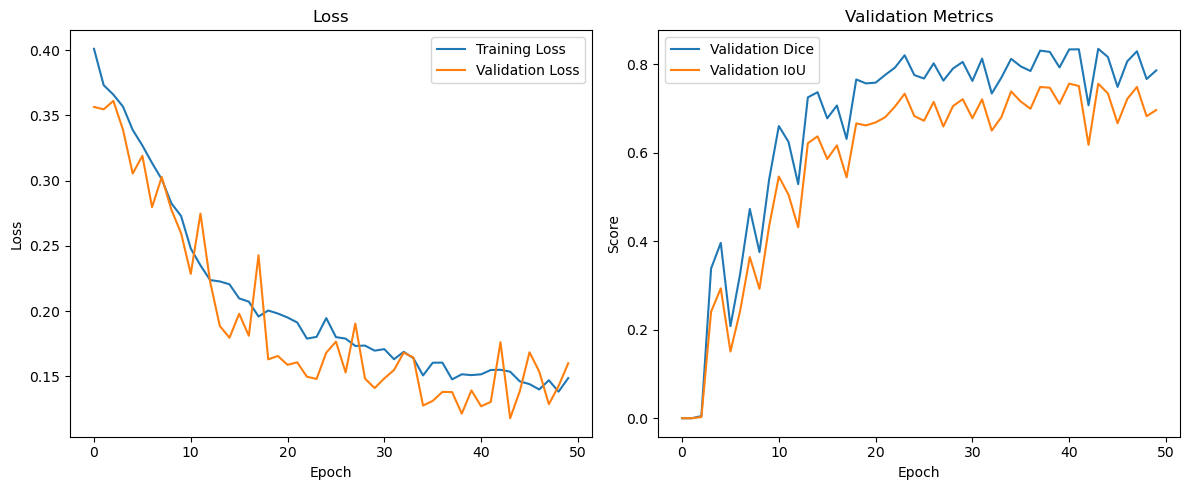

In [72]:
# Plot the loss and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_dice_scores, label='Validation Dice')
plt.plot(val_ious, label='Validation IoU')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

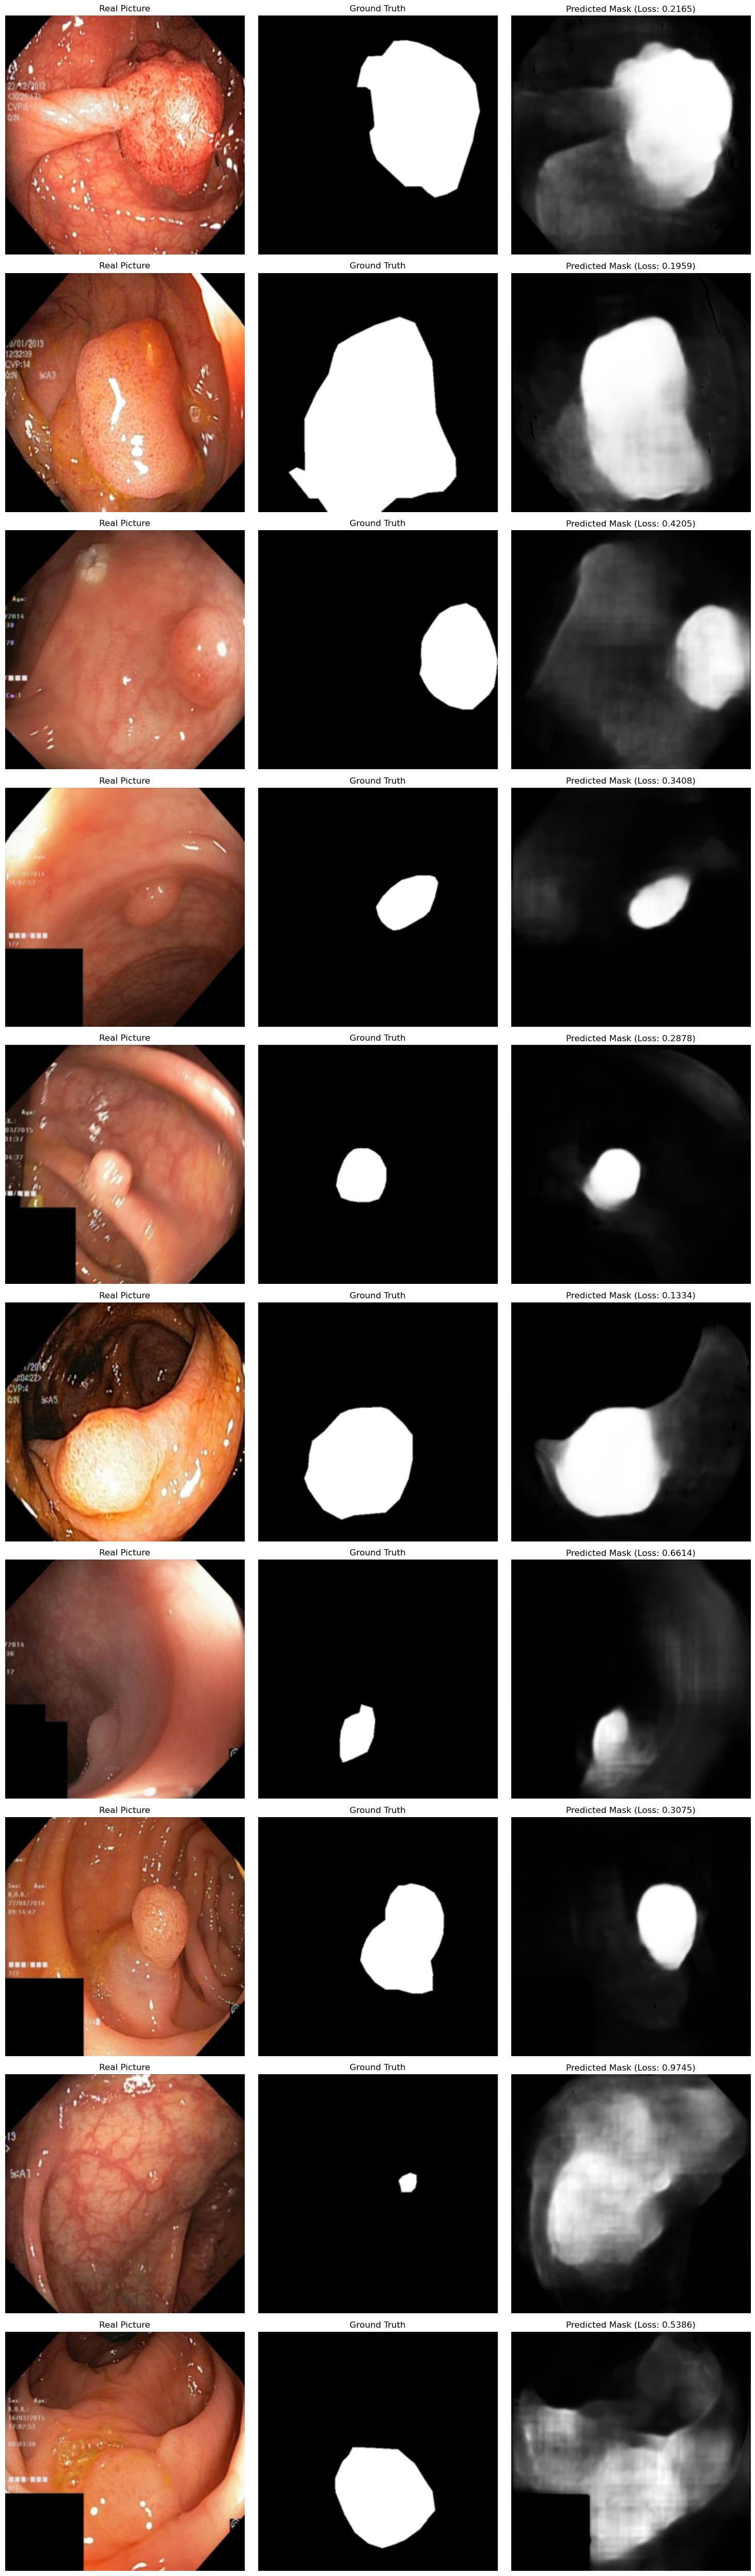

In [81]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def dice_coefficient(pred, target, smooth=1e-6):
    # Ensure the tensors have the same shape by squeezing the target
    if target.dim() == 4 and target.size(1) == 1:
        target = target.squeeze(1)
    
    # If the tensors have three dimensions (batch_size, H, W), unsqueeze the pred tensor
    if pred.dim() == 3:
        pred = pred.unsqueeze(1)
        target = target.unsqueeze(1)
    
    intersection = (pred * target).sum(dim=(1, 2, 3))
    dice = (2. * intersection + smooth) / (pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) + smooth)
    return dice.mean()

def iou(pred, target, smooth=1e-6):
    # Ensure the tensors have the same shape by squeezing the target
    if target.dim() == 4 and target.size(1) == 1:
        target = target.squeeze(1)
    
    # If the tensors have three dimensions (batch_size, H, W), unsqueeze the pred tensor
    if pred.dim() == 3:
        pred = pred.unsqueeze(1)
        target = target.unsqueeze(1)
    
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = (pred + target).sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()


def save_wrong_predictions(model, val_loader, num_images=10):
    model.eval()
    wrong_predictions = []

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = outputs.squeeze(1)  # Assuming outputs are [batch_size, 1, H, W]

            # Resizing masks if necessary
            if masks.dim() == 4 and masks.size(1) == 1:
                masks = masks.squeeze(1)

            # Iterate over the batch
            for i in range(images.size(0)):
                pred = outputs[i].unsqueeze(0)  # Select one prediction
                target = masks[i].unsqueeze(0)  # Select one ground truth mask

                # Calculate dice coefficient and loss for this prediction
                dice_score = dice_coefficient(pred, target)
                current_loss = 1 - dice_score.item()  # Loss is inverse of dice score

                if len(wrong_predictions) < num_images:
                    wrong_predictions.append((images[i], masks[i], outputs[i], current_loss))
                else:
                    # Find the max loss among the current wrong predictions
                    max_loss_entry = max(wrong_predictions, key=lambda x: x[3])
                    max_loss = max_loss_entry[3]  # Extract the scalar value for comparison

                    # Replace the entry if current_loss is larger than the max_loss found
                    if current_loss > max_loss:
                        # To avoid boolean tensor issues, use a list comprehension to find the index
                        max_idx = [entry[3] for entry in wrong_predictions].index(max_loss)
                        wrong_predictions[max_idx] = (images[i], masks[i], outputs[i], current_loss)

    return wrong_predictions






# Function to plot the most incorrect predictions
def plot_wrong_predictions(wrong_predictions):
    fig, axes = plt.subplots(len(wrong_predictions), 3, figsize=(15, len(wrong_predictions) * 5))
    
    for i, (image, mask, pred, loss) in enumerate(wrong_predictions):
        image = image.cpu().numpy().transpose(1, 2, 0)  # Convert from Tensor to NumPy array and transpose
        mask = mask.cpu().numpy()
        pred = pred.cpu().numpy()

        # Original Image
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title('Real Picture')
        axes[i, 0].axis('off')

        # Ground Truth Mask
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        # Predicted Mask
        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title('Predicted Mask (Loss: {:.4f})'.format(loss))
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Get the most incorrect predictions
wrong_predictions = save_wrong_predictions(Attntion_WD_Aug_model, val_loader, num_images=10)

# Plot the most incorrect predictions
plot_wrong_predictions(wrong_predictions)


In [84]:
# Training and validation loop
num_epochs = 50
train_losses = []
val_losses = []  # To store validation loss
val_dice_scores = []
val_ious = []

for epoch in range(num_epochs):
    Attntion_WD_Aug_model.train()
    epoch_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = Attntion_WD_Aug_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Validation
    Attntion_WD_Aug_model.eval()
    val_loss = 0.0  # Initialize validation loss
    val_dice = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = Attntion_WD_Aug_model(images)
            loss = criterion(outputs, masks)  # Compute validation loss
            val_loss += loss.item() * images.size(0)
            preds = outputs > 0.5
            val_dice += dice_coefficient(preds, masks).item() * images.size(0)
            val_iou += iou(preds, masks).item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)  # Store validation loss
    val_dice /= len(val_loader.dataset)
    val_dice_scores.append(val_dice)
    val_iou /= len(val_loader.dataset)
    val_ious.append(val_iou)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}, Validation IoU: {val_iou:.4f}')

Epoch 1/50: 100%|█████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [1/50], Loss: 0.1335
Epoch [1/50], Validation Loss: 0.1322, Validation Dice: 0.8422, Validation IoU: 0.7639


Epoch 2/50: 100%|█████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [2/50], Loss: 0.1362
Epoch [2/50], Validation Loss: 0.1242, Validation Dice: 0.8392, Validation IoU: 0.7568


Epoch 3/50: 100%|█████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [3/50], Loss: 0.1362
Epoch [3/50], Validation Loss: 0.1302, Validation Dice: 0.8273, Validation IoU: 0.7501


Epoch 4/50: 100%|█████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [4/50], Loss: 0.1315
Epoch [4/50], Validation Loss: 0.1280, Validation Dice: 0.8378, Validation IoU: 0.7581


Epoch 5/50: 100%|█████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [5/50], Loss: 0.1312
Epoch [5/50], Validation Loss: 0.1384, Validation Dice: 0.8113, Validation IoU: 0.7228


Epoch 6/50: 100%|█████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [6/50], Loss: 0.1400
Epoch [6/50], Validation Loss: 0.1372, Validation Dice: 0.8069, Validation IoU: 0.7177


Epoch 7/50: 100%|█████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [7/50], Loss: 0.1291
Epoch [7/50], Validation Loss: 0.1346, Validation Dice: 0.8354, Validation IoU: 0.7531


Epoch 8/50: 100%|█████████████████████████████| 200/200 [03:02<00:00,  1.09it/s]


Epoch [8/50], Loss: 0.1342
Epoch [8/50], Validation Loss: 0.1089, Validation Dice: 0.8316, Validation IoU: 0.7534


Epoch 9/50: 100%|█████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [9/50], Loss: 0.1358
Epoch [9/50], Validation Loss: 0.1230, Validation Dice: 0.8375, Validation IoU: 0.7623


Epoch 10/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [10/50], Loss: 0.1254
Epoch [10/50], Validation Loss: 0.1279, Validation Dice: 0.8187, Validation IoU: 0.7407


Epoch 11/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [11/50], Loss: 0.1351
Epoch [11/50], Validation Loss: 0.1324, Validation Dice: 0.8240, Validation IoU: 0.7422


Epoch 12/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [12/50], Loss: 0.1358
Epoch [12/50], Validation Loss: 0.1316, Validation Dice: 0.7828, Validation IoU: 0.7016


Epoch 13/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [13/50], Loss: 0.1328
Epoch [13/50], Validation Loss: 0.1260, Validation Dice: 0.8320, Validation IoU: 0.7562


Epoch 14/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [14/50], Loss: 0.1288
Epoch [14/50], Validation Loss: 0.1157, Validation Dice: 0.8388, Validation IoU: 0.7630


Epoch 15/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [15/50], Loss: 0.1308
Epoch [15/50], Validation Loss: 0.1276, Validation Dice: 0.8338, Validation IoU: 0.7593


Epoch 16/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [16/50], Loss: 0.1300
Epoch [16/50], Validation Loss: 0.1170, Validation Dice: 0.8250, Validation IoU: 0.7535


Epoch 17/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [17/50], Loss: 0.1223
Epoch [17/50], Validation Loss: 0.1350, Validation Dice: 0.8100, Validation IoU: 0.7317


Epoch 18/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [18/50], Loss: 0.1242
Epoch [18/50], Validation Loss: 0.1669, Validation Dice: 0.8000, Validation IoU: 0.7111


Epoch 19/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [19/50], Loss: 0.1305
Epoch [19/50], Validation Loss: 0.1255, Validation Dice: 0.8164, Validation IoU: 0.7334


Epoch 20/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [20/50], Loss: 0.1276
Epoch [20/50], Validation Loss: 0.1303, Validation Dice: 0.8306, Validation IoU: 0.7538


Epoch 21/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [21/50], Loss: 0.1255
Epoch [21/50], Validation Loss: 0.1170, Validation Dice: 0.8516, Validation IoU: 0.7784


Epoch 22/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [22/50], Loss: 0.1253
Epoch [22/50], Validation Loss: 0.2132, Validation Dice: 0.7688, Validation IoU: 0.6726


Epoch 23/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [23/50], Loss: 0.1221
Epoch [23/50], Validation Loss: 0.1175, Validation Dice: 0.8473, Validation IoU: 0.7691


Epoch 24/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [24/50], Loss: 0.1249
Epoch [24/50], Validation Loss: 0.1162, Validation Dice: 0.8454, Validation IoU: 0.7694


Epoch 25/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [25/50], Loss: 0.1278
Epoch [25/50], Validation Loss: 0.1113, Validation Dice: 0.8401, Validation IoU: 0.7670


Epoch 26/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.09it/s]


Epoch [26/50], Loss: 0.1202
Epoch [26/50], Validation Loss: 0.1251, Validation Dice: 0.8308, Validation IoU: 0.7560


Epoch 27/50: 100%|████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch [27/50], Loss: 0.1226
Epoch [27/50], Validation Loss: 0.1088, Validation Dice: 0.8576, Validation IoU: 0.7850


Epoch 28/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [28/50], Loss: 0.1155
Epoch [28/50], Validation Loss: 0.1342, Validation Dice: 0.8439, Validation IoU: 0.7701


Epoch 29/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [29/50], Loss: 0.1245
Epoch [29/50], Validation Loss: 0.1406, Validation Dice: 0.8296, Validation IoU: 0.7459


Epoch 30/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [30/50], Loss: 0.1247
Epoch [30/50], Validation Loss: 0.1339, Validation Dice: 0.8315, Validation IoU: 0.7504


Epoch 31/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [31/50], Loss: 0.1262
Epoch [31/50], Validation Loss: 0.1297, Validation Dice: 0.8363, Validation IoU: 0.7612


Epoch 32/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [32/50], Loss: 0.1232
Epoch [32/50], Validation Loss: 0.1134, Validation Dice: 0.8502, Validation IoU: 0.7758


Epoch 33/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [33/50], Loss: 0.1133
Epoch [33/50], Validation Loss: 0.1684, Validation Dice: 0.7929, Validation IoU: 0.7038


Epoch 34/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [34/50], Loss: 0.1286
Epoch [34/50], Validation Loss: 0.1307, Validation Dice: 0.8332, Validation IoU: 0.7568


Epoch 35/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [35/50], Loss: 0.1177
Epoch [35/50], Validation Loss: 0.1025, Validation Dice: 0.8595, Validation IoU: 0.7891


Epoch 36/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [36/50], Loss: 0.1116
Epoch [36/50], Validation Loss: 0.1111, Validation Dice: 0.8503, Validation IoU: 0.7759


Epoch 37/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [37/50], Loss: 0.1163
Epoch [37/50], Validation Loss: 0.1360, Validation Dice: 0.8112, Validation IoU: 0.7338


Epoch 38/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [38/50], Loss: 0.1109
Epoch [38/50], Validation Loss: 0.1193, Validation Dice: 0.8377, Validation IoU: 0.7601


Epoch 39/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.09it/s]


Epoch [39/50], Loss: 0.1047
Epoch [39/50], Validation Loss: 0.1122, Validation Dice: 0.8450, Validation IoU: 0.7734


Epoch 40/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [40/50], Loss: 0.1065
Epoch [40/50], Validation Loss: 0.1255, Validation Dice: 0.8374, Validation IoU: 0.7645


Epoch 41/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [41/50], Loss: 0.1144
Epoch [41/50], Validation Loss: 0.1233, Validation Dice: 0.8396, Validation IoU: 0.7667


Epoch 42/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [42/50], Loss: 0.1098
Epoch [42/50], Validation Loss: 0.1092, Validation Dice: 0.8345, Validation IoU: 0.7575


Epoch 43/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Epoch [43/50], Loss: 0.1017
Epoch [43/50], Validation Loss: 0.1134, Validation Dice: 0.8509, Validation IoU: 0.7777


Epoch 44/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [44/50], Loss: 0.1079
Epoch [44/50], Validation Loss: 0.1214, Validation Dice: 0.8481, Validation IoU: 0.7724


Epoch 45/50: 100%|████████████████████████████| 200/200 [03:05<00:00,  1.08it/s]


Epoch [45/50], Loss: 0.1082
Epoch [45/50], Validation Loss: 0.1165, Validation Dice: 0.8568, Validation IoU: 0.7876


Epoch 46/50: 100%|████████████████████████████| 200/200 [03:05<00:00,  1.08it/s]


Epoch [46/50], Loss: 0.1092
Epoch [46/50], Validation Loss: 0.1261, Validation Dice: 0.8408, Validation IoU: 0.7668


Epoch 47/50: 100%|████████████████████████████| 200/200 [03:04<00:00,  1.08it/s]


Epoch [47/50], Loss: 0.1069
Epoch [47/50], Validation Loss: 0.1348, Validation Dice: 0.8384, Validation IoU: 0.7592


Epoch 48/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [48/50], Loss: 0.1096
Epoch [48/50], Validation Loss: 0.1091, Validation Dice: 0.8573, Validation IoU: 0.7837


Epoch 49/50: 100%|████████████████████████████| 200/200 [03:02<00:00,  1.09it/s]


Epoch [49/50], Loss: 0.1202
Epoch [49/50], Validation Loss: 0.1235, Validation Dice: 0.8524, Validation IoU: 0.7757


Epoch 50/50: 100%|████████████████████████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch [50/50], Loss: 0.1135
Epoch [50/50], Validation Loss: 0.1101, Validation Dice: 0.8571, Validation IoU: 0.7833
